In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import random
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier

In [2]:
dat = pd.read_csv('F:\Lab\Majo Data\SKMEL-shape descriptors.csv', header = 0)
data = dat.copy()

In [3]:
# split the x part and y part
y = data.Extr
x = data.drop('Extr',axis=1)

In [4]:
def preprocessingPCA(x, y, test_size = 0.2):
    # split data into training and test sets
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
    
    # seperate the numerical part to apply for PCA 
    x_train_numeric = x_train[['area', 'Perim', 'Mayor', 'Minor', 'Circ', 'Ar', 'Round ', 'Solidity']]
    x_test_numeric = x_test[['area', 'Perim', 'Mayor', 'Minor', 'Circ', 'Ar', 'Round ', 'Solidity']]
    
    x_train_numeric_new = x_train_numeric.reset_index()
    x_train_index = x_train_numeric_new['index']

    x_test_numeric_new = x_test_numeric.reset_index()
    x_test_index = x_test_numeric_new['index']
    
    pca_train = x_train_numeric_new.drop('index', axis = 1)
    pca_test = x_test_numeric_new.drop('index', axis = 1)

    return(x_train_index, x_test_index, pca_train, pca_test, x_train, x_test, y_train, y_test)

In [5]:
x_train_index, x_test_index, prep_train, prep_test, x_train, x_test, y_train, y_test = preprocessingPCA(x, y, test_size = 0.2)

In [6]:
def myStandardscaler(train, test):
    scaler = StandardScaler()
    scaler.fit(train)
    
    scaler_train = scaler.transform(train)
    scaler_test = scaler.transform(test)
    
    return(scaler_train, scaler_test)

In [7]:
scaler_train, scaler_test = myStandardscaler(prep_train, prep_test)

**PCA with all the components**

Text(0, 0.5, 'cumulative explained variance')

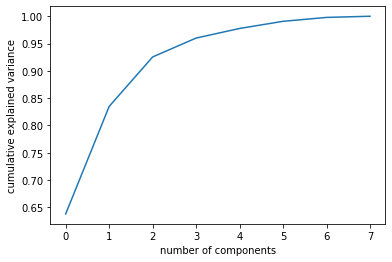

In [9]:
pca_original = PCA().fit(scaler_train)

plt.plot(np.cumsum(pca_original.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

**PCA with only two components**

In [11]:
pca_2comp = PCA(n_components = 2)
pca_components = pca_2comp.fit_transform(scaler_train)

pcaDf = pd.DataFrame(data = pca_components
             , columns = ['principal component 1', 'principal component 2'], index = x_train_index)

finalDf = pd.concat([pcaDf, y_train], axis = 1)
map_Extr = {0 : 'F', 1 : 'T'}
finalDf['Extr'] = finalDf['Extr'].map(map_Extr)

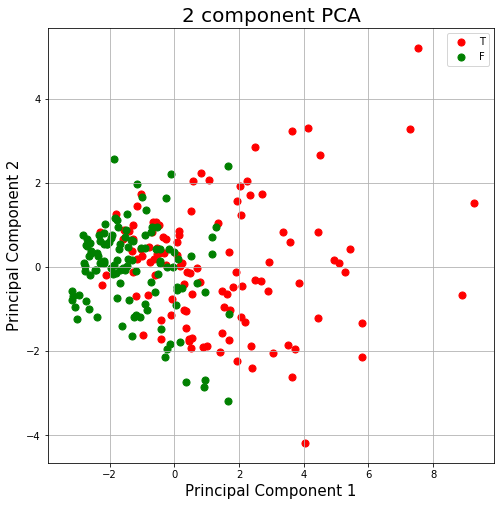

In [12]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['T', 'F']
colors = ['r', 'g']
for Extr, color in zip(targets,colors):
    indicesToKeep = finalDf['Extr'] == Extr
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

#plt.savefig("F:/Lab/Majo Data/Results/PCA_2 component.jpg")

**PCA with 3 components(the ability to explain 90% variance) and feature weights**

In [13]:
def myPCA(scaler_train, scaler_test, x_train_index, x_test_index):
    pca = PCA(0.9).fit(scaler_train)
    feature_weights = pca.components_
    
    pca_train = pd.DataFrame(pca.transform(scaler_train), index = x_train_index)
    pca_test = pd.DataFrame(pca.transform(scaler_test), index = x_test_index)
    
    return(pca_train, pca_test, feature_weights)

In [14]:
pca_train, pca_test, feature_weights = myPCA(scaler_train, scaler_test, x_train_index, x_test_index)

In [16]:
feature_weights

array([[ 0.36903283,  0.41407316,  0.41540659,  0.17496986, -0.32903214,
         0.34972508, -0.35461933, -0.36449481],
       [ 0.38309461,  0.18231834,  0.09090467,  0.69741668,  0.14290535,
        -0.37031356,  0.35589427,  0.20280545],
       [ 0.21683165, -0.02104452,  0.34403492, -0.13902822,  0.69049512,
         0.37428998, -0.16200825,  0.41440212]])

<Figure size 144x144 with 0 Axes>

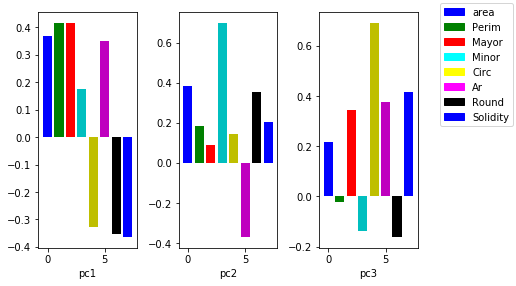

In [32]:
%matplotlib inline
fig = plt.figure(figsize=(2,2))

fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.bar(range(8),feature_weights[0],color=['b','g','r','c','y','m','k','b'])
ax2.bar(range(8),feature_weights[1],color=['b','g','r','c','y','m','k','b'])
ax3.bar(range(8),feature_weights[2],color=['b','g','r','c','y','m','k','b'])

ax1.set_xlabel('pc1')
ax2.set_xlabel('pc2')
ax3.set_xlabel('pc3')

colors = {'area':'blue', 'Perim':'green', 'Mayor':'red', 'Minor':'cyan', 'Circ':'yellow', 'Ar':'magenta', 'Round':'black', 'Solidity':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
fig.legend(handles, labels, bbox_to_anchor=(1.2, 1))


fig.tight_layout()

fig.savefig("F:/Lab/Majo Data/Results/feature_weights.jpg", bbox_inches='tight')